#CS5621 - Machine Learning Part 02
## Programming Assignment
Thennakoon T.M.B.S.B 219412A

Please upload the zip file of the Fake_Digits folders as 'Fake_Digits' to run the  code from section "Evaluation the Generated Fake Dataset by GAN".


## Imports

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose, Grayscale
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
import random
import pickle
import os
from zipfile import ZipFile
from tqdm.notebook import tqdm
from google.colab import files

# Dataset

## Importing Data

In [4]:
data_transforms = Compose([ToTensor(), Normalize(mean =(0.5), std=(0.5))])


train_dataset = MNIST(root = 'data/',
                download= True,
                train=True,
                transform = data_transforms)

test_dataset = MNIST(root = 'data/',
                download= False,
                transform = data_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
print( "Train Dataset Size:", train_dataset.data.size())
print( "Test Dataset Size:", test_dataset.data.size())

Train Dataset Size: torch.Size([60000, 28, 28])
Test Dataset Size: torch.Size([60000, 28, 28])


## Denormalize images

In [6]:
def denorm(x):  ## Denormalize the images for viewing
    out = (x + 1) / 2
    return out.clamp(0, 1)

## Show sample images from the dataset

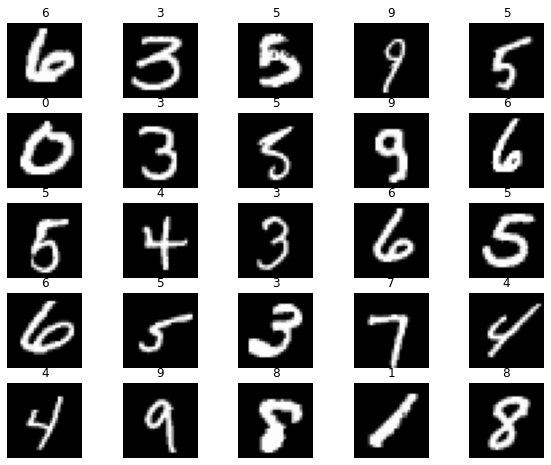

In [7]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(denorm(img.squeeze()), cmap="gray")
plt.show()

# Moving Tensors/Models to GPU

In [8]:
def get_default_device(): 
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


def to_device(data, device):
  """ Move tensors to choosen device """
  if isinstance(data, (list, tuple)) :
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

### DeviceDataLoader Class
Code Credits: https://www.youtube.com/watch?v=EHuACSjijbI&list=PLyMom0n-MBroupZiLfVSZqK5asX8KfoHL&index=5

This is a wrapper for data loader class and can be used to easily transfer data loaders to the GPU.

In [9]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    """ Wrap a data loader to  move a device to data loader """
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    """ Yield a batch of data after moving it to the device """
    for b in self.dl: 
      yield to_device(b, self.device)
  
  def __len__(self):
    """ No of batches"""
    return (self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

#GAN

In [ ]:
gan_batch_size =100
latent_size  = 64 #Size of latent vectors
image_dim = train_dataset.data.size()[1] * train_dataset.data.size()[2]
print("Image Dimensions:", image_dim)

Image Dimensions: 784


## Models

### Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
    nn.Linear(image_dim, 1024),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3), 
    nn.Linear(256, 128),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3), 
    nn.Linear(128, 1),
    nn.Sigmoid()
    )

  def forward(self, xb):
    return self.network(xb)

In [ ]:
# Create the discriminator and move it to GPU
discriminator = Discriminator()
to_device(discriminator,device)

Discriminator(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

### Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, image_dim),
    nn.Tanh())

  def forward(self, xb):
    return self.network(xb)

In [ ]:
# Create the generator and move it GPU
generator = Generator()
to_device(generator, device)

Generator(
  (network): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

## Training 

### Discriminator Training

### Evaluate Discriminator Training Accuracy

In [ ]:
def bin_accuracy(preds, labels): ## Calculates the accuracy of binary classification
  assert labels.size() == preds.size()
  preds = preds > 0.5
  return torch.tensor((labels == preds).sum().item() / labels.size(0))

In [ ]:
def train_discriminator(images, d_optimizer, loss_function):
  
  # Labelling real images as 1 and fake ones as 0
  real_labels = torch.ones(gan_batch_size, 1).to(device)
  fake_labels = torch.zeros(gan_batch_size, 1).to(device)

  # Loss And Accuracy - Real images
  real_output = discriminator(images)
  real_d_loss = loss_function(real_output, real_labels)
  real_acc = bin_accuracy(real_output, real_labels)


  #Loss and Accuracy - Fake : To calculate  fake loss and acc , we use the generator to generate fake images
  latent_vectors =  torch.randn(gan_batch_size, latent_size).to(device)
  
  fake_images = generator(latent_vectors)
  fake_output = discriminator(fake_images)
  fake_d_loss= loss_function(fake_output, fake_labels)
  fake_acc = bin_accuracy(fake_output, fake_labels)

  # Caculate combine loss and accuracy
  d_loss = fake_d_loss + real_d_loss
  d_acc  = (fake_acc + real_acc)/2

  # reset_grad()
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()

  return  d_loss, d_acc, real_output, fake_output

### Generator Training

In [ ]:
def train_generator(g_optimizer, loss_function):
  latent_vectors =  torch.randn(gan_batch_size, latent_size).to(device)
  labels = torch.ones(gan_batch_size, 1).to(device) # Label the generated latent vectors as real vectors

  # Forward pass of the generator
  gen_output = generator(latent_vectors)
  g_loss = loss_function(discriminator(gen_output), labels)  # We use the predictions of the generated  image by discriminator to train the generator

  #Backpropagation
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()
  
  return g_loss, gen_output

## Model Fitting 

### Save an image grid 

In [ ]:
def save_image_grid(images, index,sample_dir):

  if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

  fake_images = images.reshape(images.size(0), 1, 28, 28)[0:100]
  filename = 'generated-image-{0:0=4d}.png'.format(index)
  print('Saving : ', filename)
  save_image(denorm(fake_images), os.path.join(sample_dir, filename), nrow=10)

In [ ]:
TRAIN_IMAGES_DIRECTORY ='train_images_grids'

In [ ]:
sample_latent_vectors = torch.randn(gan_batch_size, latent_size).to(device)
pre_trained_g = generator(sample_latent_vectors)
pre_trained_g.size()

torch.Size([100, 784])

Saving :  generated-image-0000.png


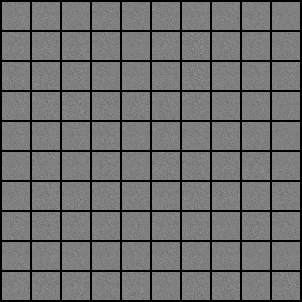

In [ ]:
save_image_grid(pre_trained_g, 0, TRAIN_IMAGES_DIRECTORY )
Image(os.path.join(TRAIN_IMAGES_DIRECTORY , 'generated-image-0000.png'))

### Fitting the GAN

In [ ]:
gan_train_data_loader = DataLoader(train_dataset, gan_batch_size, shuffle=True)

In [ ]:
def fit_GAN(num_epochs, lr, loss_function):
  
  torch.cuda.empty_cache()

  # Set the optimizers  for Generator and Discriminator (Adam Opitimizer) 
  d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  history = []
  
  for epoch in range(num_epochs):
    d_losses, g_losses, real_scores, fake_scores, d_accuracy = [], [], [], [], []
    
    for images, _ in tqdm(gan_train_data_loader):

      images = images.reshape(gan_batch_size, -1).to(device)

      # Feed the images to the discriminator to train it
      d_loss, d_acc, real_score, fake_score = train_discriminator(images,
                                                                  d_optimizer, loss_function)
      # Training the generator using the discriminator trained in the previous step
      g_loss, fake_images = train_generator(g_optimizer, loss_function)

      # Adding per batch  stats to arrays      
      d_losses.append(d_loss)
      d_accuracy.append(d_acc)
      g_losses.append(g_loss)
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())

    # Saving the per epoch stats in a dicitonary
    stats= dict()
    stats['d_loss'] =  torch.stack(d_losses).mean().item()
    stats['g_loss'] =  torch.stack(g_losses).mean().item()
    stats['d_accuracy'] =  torch.stack(d_accuracy).mean().item()
    stats['fake_score'] =  np.mean(fake_scores)
    stats['real_score'] =  np.mean(real_scores)
    

    history.append(stats)
    
    print('Epoch [{}/{}], d_acc:{:.4f}, d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
            .format(epoch+1, num_epochs, stats['d_accuracy'], stats['d_loss'],stats['g_loss'], 
                    stats['real_score'], stats['fake_score']))

    # Saving a grid of images generated the generator, to manually check the progress
    if (epoch % 5 == 0) :
      sample_latent_vectors = torch.randn(gan_batch_size, latent_size).to(device)
      training_g = generator(sample_latent_vectors)
      save_image_grid(training_g, epoch+1, TRAIN_IMAGES_DIRECTORY)

  return history

### GAN Hyperparameters

In [ ]:
loss_function = nn.BCELoss() # The Loss of function for generator and discriminator : Binary Cross Entropy
lr = 0.0002 # Learning rate for Generator and Discrimintator  Optimizers
gan_epochs = 150

In [ ]:
gan_history = fit_GAN(gan_epochs, lr, loss_function)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/150], d_acc:0.7998, d_loss: 0.8294, g_loss: 1.9794, D(x): 0.79, D(G(z)): 0.35
Saving :  generated-image-0001.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/150], d_acc:0.8781, d_loss: 0.6122, g_loss: 2.7028, D(x): 0.82, D(G(z)): 0.20


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/150], d_acc:0.9175, d_loss: 0.4347, g_loss: 2.8562, D(x): 0.87, D(G(z)): 0.13


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/150], d_acc:0.9430, d_loss: 0.3261, g_loss: 3.1162, D(x): 0.91, D(G(z)): 0.09


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/150], d_acc:0.9368, d_loss: 0.3618, g_loss: 3.0232, D(x): 0.90, D(G(z)): 0.10


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [6/150], d_acc:0.9181, d_loss: 0.4419, g_loss: 2.5490, D(x): 0.87, D(G(z)): 0.13
Saving :  generated-image-0006.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [7/150], d_acc:0.8684, d_loss: 0.6328, g_loss: 2.0885, D(x): 0.80, D(G(z)): 0.20


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [8/150], d_acc:0.8042, d_loss: 0.8469, g_loss: 1.6552, D(x): 0.73, D(G(z)): 0.28


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [9/150], d_acc:0.8031, d_loss: 0.8520, g_loss: 1.6236, D(x): 0.72, D(G(z)): 0.28


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [10/150], d_acc:0.7776, d_loss: 0.9238, g_loss: 1.4906, D(x): 0.70, D(G(z)): 0.31


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [11/150], d_acc:0.7642, d_loss: 0.9707, g_loss: 1.4062, D(x): 0.68, D(G(z)): 0.32
Saving :  generated-image-0011.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [12/150], d_acc:0.7520, d_loss: 1.0084, g_loss: 1.3376, D(x): 0.67, D(G(z)): 0.34


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [13/150], d_acc:0.7456, d_loss: 1.0272, g_loss: 1.3096, D(x): 0.66, D(G(z)): 0.34


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [14/150], d_acc:0.7313, d_loss: 1.0619, g_loss: 1.2433, D(x): 0.64, D(G(z)): 0.36


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [15/150], d_acc:0.7243, d_loss: 1.0768, g_loss: 1.2234, D(x): 0.64, D(G(z)): 0.36


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [16/150], d_acc:0.7225, d_loss: 1.0819, g_loss: 1.2125, D(x): 0.63, D(G(z)): 0.37
Saving :  generated-image-0016.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [17/150], d_acc:0.7211, d_loss: 1.0862, g_loss: 1.1942, D(x): 0.63, D(G(z)): 0.37


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [18/150], d_acc:0.7171, d_loss: 1.0953, g_loss: 1.1795, D(x): 0.63, D(G(z)): 0.37


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [19/150], d_acc:0.7154, d_loss: 1.0994, g_loss: 1.1679, D(x): 0.63, D(G(z)): 0.37


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [20/150], d_acc:0.7161, d_loss: 1.0967, g_loss: 1.1712, D(x): 0.63, D(G(z)): 0.37


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [21/150], d_acc:0.7128, d_loss: 1.1064, g_loss: 1.1581, D(x): 0.62, D(G(z)): 0.38
Saving :  generated-image-0021.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [22/150], d_acc:0.7084, d_loss: 1.1168, g_loss: 1.1391, D(x): 0.62, D(G(z)): 0.38


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [23/150], d_acc:0.7050, d_loss: 1.1195, g_loss: 1.1372, D(x): 0.62, D(G(z)): 0.38


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [24/150], d_acc:0.7041, d_loss: 1.1229, g_loss: 1.1222, D(x): 0.62, D(G(z)): 0.38


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [25/150], d_acc:0.6963, d_loss: 1.1377, g_loss: 1.1052, D(x): 0.61, D(G(z)): 0.39


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [26/150], d_acc:0.6935, d_loss: 1.1426, g_loss: 1.0926, D(x): 0.61, D(G(z)): 0.39
Saving :  generated-image-0026.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [27/150], d_acc:0.6941, d_loss: 1.1440, g_loss: 1.0920, D(x): 0.61, D(G(z)): 0.39


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [28/150], d_acc:0.6909, d_loss: 1.1500, g_loss: 1.0824, D(x): 0.61, D(G(z)): 0.39


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [29/150], d_acc:0.6856, d_loss: 1.1588, g_loss: 1.0717, D(x): 0.60, D(G(z)): 0.40


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [30/150], d_acc:0.6855, d_loss: 1.1591, g_loss: 1.0651, D(x): 0.60, D(G(z)): 0.40


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [31/150], d_acc:0.6822, d_loss: 1.1695, g_loss: 1.0514, D(x): 0.60, D(G(z)): 0.40
Saving :  generated-image-0031.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [32/150], d_acc:0.6806, d_loss: 1.1755, g_loss: 1.0369, D(x): 0.60, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [33/150], d_acc:0.6814, d_loss: 1.1715, g_loss: 1.0451, D(x): 0.60, D(G(z)): 0.40


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [34/150], d_acc:0.6784, d_loss: 1.1733, g_loss: 1.0442, D(x): 0.60, D(G(z)): 0.40


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [35/150], d_acc:0.6775, d_loss: 1.1785, g_loss: 1.0326, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [36/150], d_acc:0.6761, d_loss: 1.1830, g_loss: 1.0317, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0036.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [37/150], d_acc:0.6737, d_loss: 1.1851, g_loss: 1.0230, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [38/150], d_acc:0.6743, d_loss: 1.1881, g_loss: 1.0189, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [39/150], d_acc:0.6740, d_loss: 1.1838, g_loss: 1.0293, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [40/150], d_acc:0.6705, d_loss: 1.1915, g_loss: 1.0094, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [41/150], d_acc:0.6704, d_loss: 1.1939, g_loss: 1.0091, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0041.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [42/150], d_acc:0.6688, d_loss: 1.1962, g_loss: 1.0096, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [43/150], d_acc:0.6668, d_loss: 1.1989, g_loss: 1.0029, D(x): 0.59, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [44/150], d_acc:0.6677, d_loss: 1.1941, g_loss: 1.0116, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [45/150], d_acc:0.6683, d_loss: 1.1949, g_loss: 1.0117, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [46/150], d_acc:0.6685, d_loss: 1.1958, g_loss: 1.0112, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0046.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [47/150], d_acc:0.6676, d_loss: 1.1956, g_loss: 1.0081, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [48/150], d_acc:0.6664, d_loss: 1.2006, g_loss: 1.0016, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [49/150], d_acc:0.6664, d_loss: 1.2021, g_loss: 0.9980, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [50/150], d_acc:0.6666, d_loss: 1.1991, g_loss: 0.9980, D(x): 0.59, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [51/150], d_acc:0.6693, d_loss: 1.1941, g_loss: 1.0062, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0051.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [52/150], d_acc:0.6644, d_loss: 1.1992, g_loss: 0.9978, D(x): 0.59, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [53/150], d_acc:0.6641, d_loss: 1.2012, g_loss: 0.9920, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [54/150], d_acc:0.6644, d_loss: 1.2030, g_loss: 0.9935, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [55/150], d_acc:0.6637, d_loss: 1.2021, g_loss: 0.9943, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [56/150], d_acc:0.6649, d_loss: 1.2021, g_loss: 0.9901, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0056.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [57/150], d_acc:0.6631, d_loss: 1.2063, g_loss: 0.9875, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [58/150], d_acc:0.6624, d_loss: 1.2076, g_loss: 0.9870, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [59/150], d_acc:0.6615, d_loss: 1.2053, g_loss: 0.9894, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [60/150], d_acc:0.6656, d_loss: 1.2000, g_loss: 0.9981, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [61/150], d_acc:0.6624, d_loss: 1.2066, g_loss: 0.9845, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0061.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [62/150], d_acc:0.6659, d_loss: 1.1999, g_loss: 0.9961, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [63/150], d_acc:0.6616, d_loss: 1.2055, g_loss: 0.9796, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [64/150], d_acc:0.6625, d_loss: 1.2035, g_loss: 0.9887, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [65/150], d_acc:0.6623, d_loss: 1.2040, g_loss: 0.9922, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [66/150], d_acc:0.6625, d_loss: 1.2045, g_loss: 0.9881, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0066.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [67/150], d_acc:0.6616, d_loss: 1.2072, g_loss: 0.9761, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [68/150], d_acc:0.6642, d_loss: 1.2028, g_loss: 0.9842, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [69/150], d_acc:0.6623, d_loss: 1.2062, g_loss: 0.9843, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [70/150], d_acc:0.6617, d_loss: 1.2068, g_loss: 0.9812, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [71/150], d_acc:0.6630, d_loss: 1.2029, g_loss: 0.9896, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0071.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [72/150], d_acc:0.6635, d_loss: 1.2034, g_loss: 0.9844, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [73/150], d_acc:0.6642, d_loss: 1.2037, g_loss: 0.9874, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [74/150], d_acc:0.6632, d_loss: 1.2008, g_loss: 0.9898, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [75/150], d_acc:0.6657, d_loss: 1.1986, g_loss: 0.9912, D(x): 0.59, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [76/150], d_acc:0.6621, d_loss: 1.2063, g_loss: 0.9773, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0076.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [77/150], d_acc:0.6627, d_loss: 1.2040, g_loss: 0.9803, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [78/150], d_acc:0.6635, d_loss: 1.2061, g_loss: 0.9848, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [79/150], d_acc:0.6619, d_loss: 1.2056, g_loss: 0.9828, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [80/150], d_acc:0.6625, d_loss: 1.2039, g_loss: 0.9811, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [81/150], d_acc:0.6610, d_loss: 1.2071, g_loss: 0.9794, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0081.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [82/150], d_acc:0.6642, d_loss: 1.2033, g_loss: 0.9920, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [83/150], d_acc:0.6621, d_loss: 1.2090, g_loss: 0.9775, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [84/150], d_acc:0.6633, d_loss: 1.2034, g_loss: 0.9783, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [85/150], d_acc:0.6618, d_loss: 1.2058, g_loss: 0.9825, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [86/150], d_acc:0.6633, d_loss: 1.2024, g_loss: 0.9834, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0086.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [87/150], d_acc:0.6604, d_loss: 1.2049, g_loss: 0.9766, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [88/150], d_acc:0.6619, d_loss: 1.2063, g_loss: 0.9818, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [89/150], d_acc:0.6616, d_loss: 1.2080, g_loss: 0.9726, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [90/150], d_acc:0.6625, d_loss: 1.2067, g_loss: 0.9728, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [91/150], d_acc:0.6603, d_loss: 1.2093, g_loss: 0.9737, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0091.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [92/150], d_acc:0.6615, d_loss: 1.2064, g_loss: 0.9744, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [93/150], d_acc:0.6619, d_loss: 1.2050, g_loss: 0.9801, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [94/150], d_acc:0.6615, d_loss: 1.2054, g_loss: 0.9735, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [95/150], d_acc:0.6622, d_loss: 1.2041, g_loss: 0.9767, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [96/150], d_acc:0.6625, d_loss: 1.2051, g_loss: 0.9850, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0096.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [97/150], d_acc:0.6654, d_loss: 1.2014, g_loss: 0.9835, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [98/150], d_acc:0.6649, d_loss: 1.2012, g_loss: 0.9860, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [99/150], d_acc:0.6658, d_loss: 1.2012, g_loss: 0.9860, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [100/150], d_acc:0.6644, d_loss: 1.2020, g_loss: 0.9857, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [101/150], d_acc:0.6632, d_loss: 1.2056, g_loss: 0.9790, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0101.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [102/150], d_acc:0.6643, d_loss: 1.2020, g_loss: 0.9855, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [103/150], d_acc:0.6644, d_loss: 1.2030, g_loss: 0.9918, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [104/150], d_acc:0.6632, d_loss: 1.2014, g_loss: 0.9798, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [105/150], d_acc:0.6656, d_loss: 1.1998, g_loss: 0.9824, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [106/150], d_acc:0.6639, d_loss: 1.2028, g_loss: 0.9851, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0106.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [107/150], d_acc:0.6648, d_loss: 1.2008, g_loss: 0.9870, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [108/150], d_acc:0.6642, d_loss: 1.2015, g_loss: 0.9838, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [109/150], d_acc:0.6656, d_loss: 1.1965, g_loss: 0.9865, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [110/150], d_acc:0.6646, d_loss: 1.1998, g_loss: 0.9801, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [111/150], d_acc:0.6642, d_loss: 1.2003, g_loss: 0.9851, D(x): 0.58, D(G(z)): 0.42
Saving :  generated-image-0111.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [112/150], d_acc:0.6626, d_loss: 1.2029, g_loss: 0.9837, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [113/150], d_acc:0.6615, d_loss: 1.2076, g_loss: 0.9811, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [114/150], d_acc:0.6635, d_loss: 1.2023, g_loss: 0.9832, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [115/150], d_acc:0.6637, d_loss: 1.1995, g_loss: 0.9848, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [116/150], d_acc:0.6673, d_loss: 1.1964, g_loss: 0.9939, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0116.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [117/150], d_acc:0.6660, d_loss: 1.1984, g_loss: 0.9930, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [118/150], d_acc:0.6661, d_loss: 1.1974, g_loss: 0.9948, D(x): 0.58, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [119/150], d_acc:0.6657, d_loss: 1.1985, g_loss: 0.9876, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [120/150], d_acc:0.6667, d_loss: 1.1977, g_loss: 0.9863, D(x): 0.59, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [121/150], d_acc:0.6663, d_loss: 1.1994, g_loss: 0.9910, D(x): 0.58, D(G(z)): 0.41
Saving :  generated-image-0121.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [122/150], d_acc:0.6666, d_loss: 1.1981, g_loss: 0.9959, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [123/150], d_acc:0.6661, d_loss: 1.1999, g_loss: 0.9874, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [124/150], d_acc:0.6656, d_loss: 1.1988, g_loss: 0.9885, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [125/150], d_acc:0.6644, d_loss: 1.2001, g_loss: 0.9841, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [126/150], d_acc:0.6655, d_loss: 1.1980, g_loss: 0.9886, D(x): 0.59, D(G(z)): 0.42
Saving :  generated-image-0126.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [127/150], d_acc:0.6655, d_loss: 1.1993, g_loss: 0.9909, D(x): 0.59, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [128/150], d_acc:0.6663, d_loss: 1.1972, g_loss: 0.9894, D(x): 0.59, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [129/150], d_acc:0.6673, d_loss: 1.1976, g_loss: 0.9901, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [130/150], d_acc:0.6674, d_loss: 1.1984, g_loss: 0.9893, D(x): 0.58, D(G(z)): 0.42


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [131/150], d_acc:0.6653, d_loss: 1.1956, g_loss: 0.9886, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0131.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [132/150], d_acc:0.6684, d_loss: 1.1917, g_loss: 0.9998, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [133/150], d_acc:0.6681, d_loss: 1.1944, g_loss: 0.9871, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [134/150], d_acc:0.6678, d_loss: 1.1944, g_loss: 0.9914, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [135/150], d_acc:0.6678, d_loss: 1.1953, g_loss: 0.9926, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [136/150], d_acc:0.6660, d_loss: 1.1978, g_loss: 0.9918, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0136.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [137/150], d_acc:0.6698, d_loss: 1.1894, g_loss: 0.9985, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [138/150], d_acc:0.6691, d_loss: 1.1925, g_loss: 0.9918, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [139/150], d_acc:0.6677, d_loss: 1.1936, g_loss: 0.9942, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [140/150], d_acc:0.6696, d_loss: 1.1922, g_loss: 0.9979, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [141/150], d_acc:0.6690, d_loss: 1.1921, g_loss: 0.9979, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0141.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [142/150], d_acc:0.6682, d_loss: 1.1946, g_loss: 0.9957, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [143/150], d_acc:0.6686, d_loss: 1.1919, g_loss: 0.9990, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [144/150], d_acc:0.6707, d_loss: 1.1902, g_loss: 1.0016, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [145/150], d_acc:0.6717, d_loss: 1.1868, g_loss: 1.0024, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [146/150], d_acc:0.6707, d_loss: 1.1891, g_loss: 1.0066, D(x): 0.59, D(G(z)): 0.41
Saving :  generated-image-0146.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [147/150], d_acc:0.6692, d_loss: 1.1905, g_loss: 0.9987, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [148/150], d_acc:0.6731, d_loss: 1.1866, g_loss: 1.0065, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [149/150], d_acc:0.6717, d_loss: 1.1871, g_loss: 1.0079, D(x): 0.59, D(G(z)): 0.41


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [150/150], d_acc:0.6700, d_loss: 1.1882, g_loss: 1.0086, D(x): 0.59, D(G(z)): 0.41


### GAN training plots

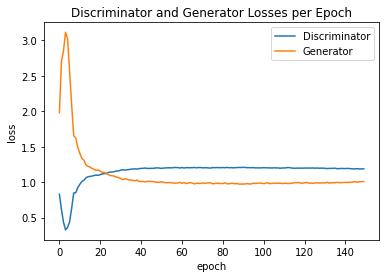

In [ ]:
d_losses = [x.get('d_loss') for x in gan_history]
g_losses = [x.get('g_loss') for x in gan_history]
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Discriminator and Generator Losses per Epoch');

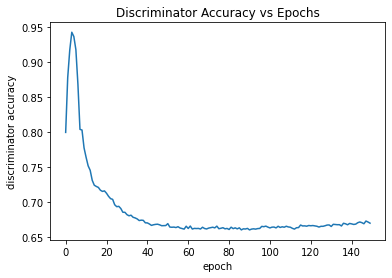

In [ ]:
real_scores = [x.get('d_accuracy') for x in gan_history]
plt.plot(real_scores, '-')
plt.xlabel('epoch')
plt.ylabel('discriminator accuracy')
plt.title('Discriminator Accuracy vs Epochs');

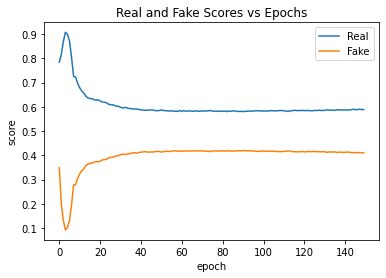

In [ ]:
real_scores = [x.get('real_score') for x in gan_history]
fake_scores = [x.get('fake_score') for x in gan_history]
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Real and Fake Scores vs Epochs');

### Writing Epoch stats to text file in latex table format

In [ ]:
file = open('gan_epoch_history.txt', 'w') # write to file
for i, result in enumerate(gan_history):
     file.write(str(i+1)+ " & " + str(round(result['d_accuracy'], 4)) 
     +" & " + str(round(result['d_loss'],4)) + " & " + str(round(result['g_loss'],4)) +
      " \\\ \n")
file.close() # close file

## Generating the fake dataset

In [ ]:
FAKE_IMAGE_GRID_DIRECTORY = 'fake_image_grid'
FAKE_IMAGES_DIRECTORY ='fake_images'
os.makedirs(FAKE_IMAGES_DIRECTORY, exist_ok=True)

### Creating latent vectors and saving them

In [ ]:
test_sample_latent_vectors = torch.randn(gan_batch_size*2, latent_size).to(device)
print('Latent Vecotr Size: ',test_sample_latent_vectors.size())

Latent Vecotr Size:  torch.Size([200, 64])


In [ ]:
def write_latent_vector(path, latent_vectors):
  for i,(vector) in enumerate(latent_vectors):
    filename = str(i+1) +'.txt'
    np.savetxt(os.path.join(path, filename), vector.cpu().numpy())

write_latent_vector(FAKE_IMAGES_DIRECTORY, test_sample_latent_vectors)

### Generating fake images using the generator and saving them

Saving :  generated-image-0000.png


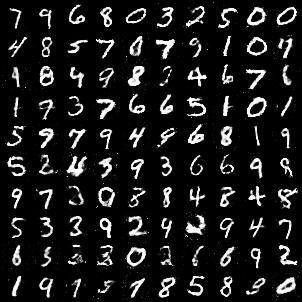

In [ ]:
test_fake_images = generator(test_sample_latent_vectors)
save_image_grid(test_fake_images,0,FAKE_IMAGE_GRID_DIRECTORY)
Image(os.path.join(FAKE_IMAGE_GRID_DIRECTORY , 'generated-image-0000.png'))

In [ ]:
test_fake_images_reshaped = test_fake_images.reshape(test_fake_images.size(0), 1, 28, 28)
print('Fake image Set Size:',test_fake_images_reshaped.size())

Fake image Set Size: torch.Size([200, 1, 28, 28])


In [ ]:
def write_image(path, images):
  for i,(image) in enumerate(images):
    filename = str(i +1) + '.png'
    save_image(denorm(image), os.path.join(path, filename))
    
write_image(FAKE_IMAGES_DIRECTORY, test_fake_images_reshaped) 

In [ ]:
# Download the generated zipFile
!zip -r fake.zip fake_images
files.download("fake.zip")

  adding: fake_images/ (stored 0%)
  adding: fake_images/189.txt (deflated 54%)
  adding: fake_images/135.png (stored 0%)
  adding: fake_images/141.txt (deflated 54%)
  adding: fake_images/181.txt (deflated 53%)
  adding: fake_images/162.png (stored 0%)
  adding: fake_images/11.txt (deflated 53%)
  adding: fake_images/43.txt (deflated 54%)
  adding: fake_images/88.png (stored 0%)
  adding: fake_images/17.png (stored 0%)
  adding: fake_images/7.png (stored 0%)
  adding: fake_images/114.png (stored 0%)
  adding: fake_images/8.txt (deflated 53%)
  adding: fake_images/23.txt (deflated 53%)
  adding: fake_images/107.txt (deflated 54%)
  adding: fake_images/6.png (stored 0%)
  adding: fake_images/178.png (stored 0%)
  adding: fake_images/155.txt (deflated 53%)
  adding: fake_images/193.png (stored 0%)
  adding: fake_images/53.txt (deflated 53%)
  adding: fake_images/33.txt (deflated 53%)
  adding: fake_images/12.png (stored 0%)
  adding: fake_images/59.png (stored 0%)
  adding: fake_images/8

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Saving the models

In [ ]:
discriminator_filename = 'D.pkl'
pickle.dump(discriminator, open(discriminator_filename,'wb'))

In [ ]:
generator_filename = 'G.pkl'
pickle.dump(generator, open(generator_filename,'wb'))

#Classifier

## Data preparation

In [11]:
#Set a random seed so, the results are reproducable
random_seed = 42
torch.manual_seed(random_seed);

### Train Validation Split

In [12]:
classifier_val_dataset_size = 12000
train_size = len(train_dataset) - classifier_val_dataset_size

classifier_train_ds, classiifer_val_ds = random_split(train_dataset, [train_size, classifier_val_dataset_size])
print('Train dataset Size: ', len(classifier_train_ds))
print('Validation dataset Size: ',len(classiifer_val_ds))

Train dataset Size:  48000
Validation dataset Size:  12000


### Creating DataLoaders

In [13]:
classifier_batch_size = 100
classifier_train_dl = DataLoader(classifier_train_ds, classifier_batch_size, shuffle=True, num_workers=2, pin_memory=True)
classifier_val_dl = DataLoader(classiifer_val_ds , classifier_batch_size*2, num_workers=2, pin_memory=True)

##Train  and Validation Steps
Code Credits: https://www.youtube.com/watch?v=EHuACSjijbI&list=PLyMom0n-MBroupZiLfVSZqK5asX8KfoHL&index=5

This class contains the common steps in training and validation of a classifier model

In [19]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels) # Calculate  loss per batch for train data
    acc  = accuracy(out, labels) #  Calculate the accuracy per batch for test data
    return loss, acc
  
  def validation_step(self, batch): # Calculates the validation accuray  and loss per each batch
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out, labels)
    return {'val_loss' : loss.detach(), 'val_acc' : acc}

  def validation_epoch_end(self, outputs): # Summarize per epoch stats
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}

  def epoch_end(self, epoch, result): 
    print ("Epoch [{}], train_loss:{:.4f}, train_accuracy:{:.4f} val_loss: {:.4f}, val_acc: {:.4f}"
           .format(epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc']))
    

def accuracy(outputs, labels): # Calculates the accuracy of multi-class classification
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() /len(preds))

## Model Fitting and Evaluation Methods

In [20]:
@torch.no_grad() #Speicifies that this method doesn't require gradients
def evaluate(model, val_loader): # Method to evaluate the model
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def fit_classifier(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history =[]
  optimizer = opt_func(model.parameters(), lr) #Set the optimizer function

  for epoch in range(epochs):
    # Training phase
    model.train()
    train_losses = []
    train_accuracies = []
    for batch in tqdm(train_loader):
      #Caclulate the loss (Forward pass)
      loss, acc = model.training_step(batch)
      train_losses.append(loss)
      train_accuracies.append(acc)
      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation phase
    result = evaluate(model, val_loader)
    #Storing the stats in history list
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['train_accuracy'] = torch.stack(train_accuracies).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  
  return history

## Classifier Model

In [21]:
class MNISTCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 36, kernel_size=5,stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(36, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Dropout(0.2),

            nn.Flatten(), 
            nn.Linear(32*6*6, 10))
        
    def forward(self, xb):
        return self.network(xb)

## Classfier Training 

###  Moving Model, Data Loaders to Device

In [17]:
classifier_model = MNISTCnnModel()
to_device(classifier_model, device)

NameError: ignored

In [ ]:
classifier_train_dl = DeviceDataLoader(classifier_train_dl, device)
classifier_val_dl = DeviceDataLoader(classifier_val_dl, device)

### Classifier HyperParameters

In [ ]:
classifier_num_epochs = 25
classifier_opt_funct = torch.optim.Adam
classifier_lr = 0.0001

### Model fitting

In [ ]:
classifier_history = fit_classifier(classifier_num_epochs,classifier_lr, classifier_model, 
                         classifier_train_dl, classifier_val_dl, classifier_opt_funct)

0it [00:00, ?it/s]

Epoch [1], train_loss:0.8544, train_accuracy:0.7678 val_loss: 0.2883, val_acc: 0.9205


0it [00:00, ?it/s]

Epoch [2], train_loss:0.2411, train_accuracy:0.9301 val_loss: 0.1698, val_acc: 0.9518


0it [00:00, ?it/s]

Epoch [3], train_loss:0.1649, train_accuracy:0.9518 val_loss: 0.1274, val_acc: 0.9632


0it [00:00, ?it/s]

Epoch [4], train_loss:0.1292, train_accuracy:0.9627 val_loss: 0.1026, val_acc: 0.9692


0it [00:00, ?it/s]

Epoch [5], train_loss:0.1085, train_accuracy:0.9673 val_loss: 0.0887, val_acc: 0.9743


0it [00:00, ?it/s]

Epoch [6], train_loss:0.0958, train_accuracy:0.9714 val_loss: 0.0796, val_acc: 0.9758


0it [00:00, ?it/s]

Epoch [7], train_loss:0.0851, train_accuracy:0.9742 val_loss: 0.0704, val_acc: 0.9793


0it [00:00, ?it/s]

Epoch [8], train_loss:0.0776, train_accuracy:0.9767 val_loss: 0.0643, val_acc: 0.9803


0it [00:00, ?it/s]

Epoch [9], train_loss:0.0706, train_accuracy:0.9783 val_loss: 0.0607, val_acc: 0.9816


0it [00:00, ?it/s]

Epoch [10], train_loss:0.0664, train_accuracy:0.9797 val_loss: 0.0575, val_acc: 0.9821


0it [00:00, ?it/s]

Epoch [11], train_loss:0.0612, train_accuracy:0.9811 val_loss: 0.0557, val_acc: 0.9823


0it [00:00, ?it/s]

Epoch [12], train_loss:0.0576, train_accuracy:0.9821 val_loss: 0.0525, val_acc: 0.9843


0it [00:00, ?it/s]

Epoch [13], train_loss:0.0538, train_accuracy:0.9833 val_loss: 0.0499, val_acc: 0.9852


0it [00:00, ?it/s]

Epoch [14], train_loss:0.0507, train_accuracy:0.9846 val_loss: 0.0469, val_acc: 0.9857


0it [00:00, ?it/s]

Epoch [15], train_loss:0.0486, train_accuracy:0.9845 val_loss: 0.0455, val_acc: 0.9858


0it [00:00, ?it/s]

Epoch [16], train_loss:0.0458, train_accuracy:0.9858 val_loss: 0.0439, val_acc: 0.9865


0it [00:00, ?it/s]

Epoch [17], train_loss:0.0444, train_accuracy:0.9860 val_loss: 0.0433, val_acc: 0.9868


0it [00:00, ?it/s]

Epoch [18], train_loss:0.0420, train_accuracy:0.9873 val_loss: 0.0419, val_acc: 0.9869


0it [00:00, ?it/s]

Epoch [19], train_loss:0.0395, train_accuracy:0.9879 val_loss: 0.0402, val_acc: 0.9873


0it [00:00, ?it/s]

Epoch [20], train_loss:0.0395, train_accuracy:0.9875 val_loss: 0.0400, val_acc: 0.9878


0it [00:00, ?it/s]

Epoch [21], train_loss:0.0368, train_accuracy:0.9882 val_loss: 0.0401, val_acc: 0.9878


0it [00:00, ?it/s]

Epoch [22], train_loss:0.0371, train_accuracy:0.9881 val_loss: 0.0383, val_acc: 0.9886


0it [00:00, ?it/s]

Epoch [23], train_loss:0.0351, train_accuracy:0.9891 val_loss: 0.0369, val_acc: 0.9882


0it [00:00, ?it/s]

Epoch [24], train_loss:0.0342, train_accuracy:0.9893 val_loss: 0.0371, val_acc: 0.9884


0it [00:00, ?it/s]

Epoch [25], train_loss:0.0332, train_accuracy:0.9895 val_loss: 0.0366, val_acc: 0.9881


### Classifier Plots

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs No. of Epochs')

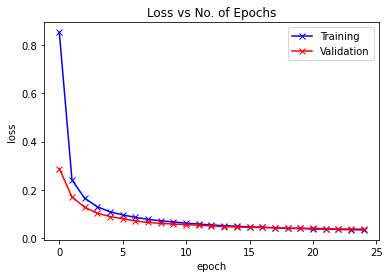

In [ ]:
plot_losses(classifier_history)

In [ ]:
def plot_accuracy(history):
  train_losses = [x.get('train_accuracy') for x in history]
  val_losses = [x['val_acc'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'])
  plt.title('Accuracy vs No. of Epochs');

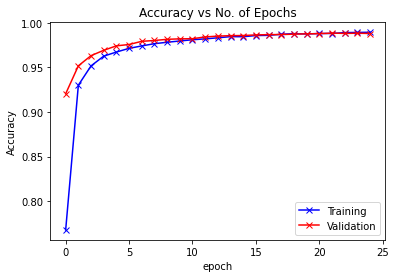

In [ ]:
plot_accuracy(classifier_history)

In [ ]:
file = open('classifier_epoch_history.txt', 'w') # write to file
for i, result in enumerate(classifier_history):
     file.write(str(i+1)+ " & " + str(round(result['train_accuracy'],4)) 
     +" & " + str(round(result['train_loss'],4)) + " & " + str(round(result['val_acc'],4)) +
     " & " + str(round(result['val_loss'], 4)) + " \\\ \n")
file.close() # close file

##  Classifier Evaluation

### Evaluating the model with complete dataset

In [23]:
classifier_test_loader = DeviceDataLoader(DataLoader(test_dataset, classifier_batch_size*2), device)


In [ ]:
complete_test_set_result = evaluate(classifier_model, classifier_test_loader)
print('Results for the complete test set:', complete_test_set_result)

## Classifier Model Saving

### Saving the model using pickle

In [14]:
classifier_filename = 'C.pkl'

In [15]:
pickle.dump(classifier_model, open(classifier_filename,'wb'))

NameError: ignored

### Verifying the saved model

In [24]:
saved_classifier = pickle.load(open(classifier_filename,'rb'))
result = evaluate(saved_classifier, classifier_test_loader)
result

{'val_acc': 0.9928999543190002, 'val_loss': 0.024175873026251793}

# Evaluating the generated fake dataset by GAN

## Obtaining some random images from the real testing dataset (S0)

In [44]:
subset_length = 100
# Creating a Subset of the dataset using random 100 indexes 
s0 = Subset(test_dataset,random.sample(range(0, len(test_dataset)), subset_length))
print('Length of the subset s0: ', len(s0))

Length of the subset s0:  100


In [45]:
s0_dl = DataLoader(s0, classifier_batch_size, num_workers=2, pin_memory=True)
s0_dl = DeviceDataLoader(s0_dl,device)

s0_result = evaluate(saved_classifier, s0_dl)
print('Results for real dataset (s0):', s0_result)

Results for real dataset (s0): {'val_loss': 0.009593496099114418, 'val_acc': 1.0}


## Loading the fake dataset
The Fake dataset is upload as zipfile name  'FakeDigits.zip'

In [32]:
#Unzipping the zipfile
with ZipFile('Fake_Digits.zip', 'r') as zipObj:
   zipObj.extractall()

###  Adding Grayscale transform to dataset obtained using Pytorch Image

In [33]:
fake_ds_transforms = Compose([data_transforms, Grayscale(num_output_channels=1)])

### Read the fake dataset using Pytorch Image Folder

In [34]:
DATA_DIR = 'Fake_Digits'
fake_ds  = ImageFolder(DATA_DIR, 
                        transform= fake_ds_transforms)
img, label = fake_ds[0]
print('Sample image dimensions',img.size())
print('Length of s1 dataset:', len(fake_ds))

Sample image dimensions torch.Size([1, 28, 28])
Length of s1 dataset: 100


### View samples from the fake dataset

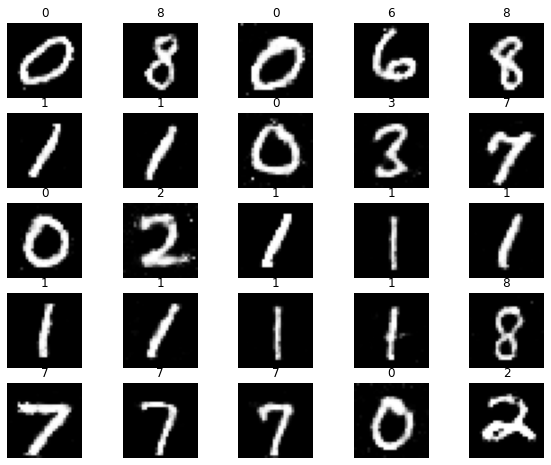

In [35]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fake_ds), size=(1,)).item()
    img, label = fake_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(denorm(img.squeeze()), cmap="gray")
plt.show()

In [38]:
s1_dl = DeviceDataLoader(DataLoader(fake_ds, subset_length, num_workers=2, pin_memory=True), device)
s1_result = evaluate(saved_classifier, s1_dl)
print('Results for real dataset (s1)', s1_result)

Results for real dataset (s1) {'val_loss': 0.0026384592056274414, 'val_acc': 1.0}
